In [1]:
# Import libraries
from transformers import AutoImageProcessor,DefaultDataCollator
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer
import torch
import os
import numpy as np
from datasets import Dataset 
from datasets import load_metric
from PIL import Image
from scipy.special import softmax
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from transformers import EarlyStoppingCallback
import pandas as pd
import pickle

# Data Preprocessing

In [2]:
label_to_str = {0: 'no_sub', 1: 'sub'}
str_to_label = {'sub': 1, 'no_sub': 0}
def create_dataset(folder_path, train_ratio=0.9):
    def get_label(file_path):
        # Extract the label from the file path
        parts = os.path.split(file_path)
        if parts[-2].split('/')[-1] == "sub":
            return 1
        else:
            return 0

    # Get the list of all image file paths
    sub_dir = os.path.join(folder_path, "sub")
    no_sub_dir = os.path.join(folder_path, "no_sub")

    sub_files = [os.path.join(sub_dir, f) for f in os.listdir(sub_dir) if f.endswith(".jpg")]
    no_sub_files = [os.path.join(no_sub_dir, f) for f in os.listdir(no_sub_dir) if f.endswith(".jpg")]

    all_files = sub_files + no_sub_files

    # Shuffle the file paths and split them into training and testing sets
    np.random.shuffle(all_files)
    split_idx = int(len(all_files) * train_ratio)
    train_files = all_files[:split_idx]
    test_files = all_files[split_idx:]

    # Create a list of dictionaries containing file paths and their corresponding labels
    train_data = [{"file_path": file_path, "label": get_label(file_path)} for file_path in train_files]
    test_data = [{"file_path": file_path, "label": get_label(file_path)} for file_path in test_files]

    # Convert the list of dictionaries to Hugging Face's Dataset objects
    train_ds = Dataset.from_dict({"file_path": [item["file_path"] for item in train_data],
                                  "label": [item["label"] for item in train_data],
                                 "image": [Image.open(item["file_path"]) for item in train_data]})
    test_ds = Dataset.from_dict({"file_path": [item["file_path"] for item in test_data],
                                 "label": [item["label"] for item in test_data],
                                "image": [Image.open(item["file_path"]) for item in test_data]})

    return train_ds, test_ds

folder_path = "lenses/lenses/"
train_ds, test_ds = create_dataset(folder_path)

label_counts = {}
for example in test_ds:
    label = example["label"]
    if label in label_counts:
        label_counts[label] += 1
    else:
        label_counts[label] = 1

# Print the label counts
print(label_counts)

{1: 505, 0: 495}


# Common helper functions for training

In [3]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}


metric = load_metric("roc_auc")
def compute_metrics(eval_pred):
    """Computes Roc_AUC on a batch of predictions"""

    probabilities = softmax(eval_pred.predictions, axis=1)[:,1]
    return metric.compute(prediction_scores=probabilities, references=eval_pred.label_ids)
# Visualize the ROC-AUC plot
def plot_roc_curve(fpr, tpr, auc_score):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC: {auc_score:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

/tmp/ipykernel_6039/710778781.py:7: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("roc_auc")


# 1st Model, Variants of Google's Vit base (https://huggingface.co/google/vit-base-patch16-224-in21k)

In [4]:
checkpoint = "google/vit-base-patch16-224-in21k"

def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)
_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])

train_ds = train_ds.with_transform(transforms)
test_ds = test_ds.with_transform(transforms)

In [5]:

training_args = TrainingArguments(
    output_dir="vit-base",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    num_train_epochs=30,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="roc_auc",
    push_to_hub=False,
)

In [6]:
do_train = False

In [7]:
if do_train:
    model = AutoModelForImageClassification.from_pretrained(
        checkpoint,
        num_labels=2,
        id2label=label_to_str,
        label2id=str_to_label,
    )
    trainer = Trainer(
        model=model,
        args=training_args,
        data_collator=collate_fn,
        train_dataset=train_ds,
        eval_dataset=test_ds,
        tokenizer=image_processor,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=5)],  # Stop training if the model is not improving for 5 consecutive evaluations
    )
    trainer.train()
    best_model = trainer.model
    best_metrics = trainer.evaluate(test_ds)
    print("Best model ROC-AUC score on the test set:", best_metrics["eval_roc_auc"])
    with open('histories/vit.pkl', 'wb') as file:
        pickle.dump(trainer.state.log_history, file)
    
    # Save the best model
    best_model.save_pretrained("vit_base")

In [8]:
loaded_model = AutoModelForImageClassification.from_pretrained("vit_base")
loaded_trainer = Trainer(
    model=loaded_model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

***** Running Prediction *****
  Num examples = 1000
  Batch size = 16


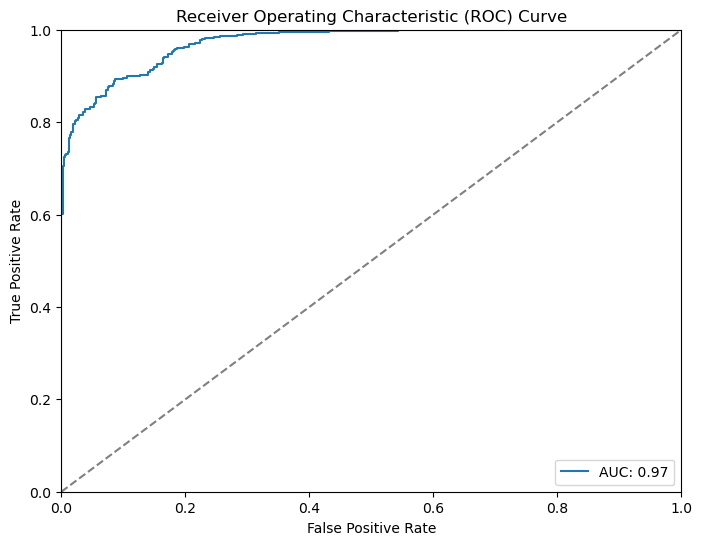

In [9]:
# Predict on the test dataset
predictions = loaded_trainer.predict(test_ds)

# Get the predicted probabilities and ground truth labels
predicted_probs = predictions.predictions[:, 1]  # Assuming class 1 is the positive class
ground_truth_labels = predictions.label_ids

# Calculate FPR, TPR, and AUC score
fpr, tpr, _ = roc_curve(ground_truth_labels, predicted_probs)
auc_score = roc_auc_score(ground_truth_labels, predicted_probs)

plot_roc_curve(fpr, tpr, auc_score)

# 2nd Model BEIT Base 16 (https://huggingface.co/microsoft/beit-base-patch16-224-pt22k-ft22k)

In [10]:
checkpoint = "microsoft/beit-base-patch16-224-pt22k-ft22k"

def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)
_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])

train_ds = train_ds.with_transform(transforms)
test_ds = test_ds.with_transform(transforms)

loading configuration file preprocessor_config.json from cache at /home/gwan/.cache/huggingface/hub/models--microsoft--beit-base-patch16-224-pt22k-ft22k/snapshots/9da301148150e37e533abef672062fa49f6bda4f/preprocessor_config.json
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
{param_name} should be a dictionary on of the following set of keys: {VALID_SIZE_DICT_KEYS}, got {size}. Converted to {size_dict}.
{param_name} should be a dictionary on of the following set of keys: {VALID_SIZE_DICT_KEYS}, got {size}. Converted to {size_dict}.
Image processor BeitImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": false,
  "do_normalize": true,
  "do_reduce_labels": false,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "BeitImageProcessor",
  "image_std": [
    0

In [11]:
training_args = TrainingArguments(
    output_dir="beit",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    num_train_epochs=30,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="roc_auc",
    push_to_hub=False,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [12]:
if do_train:
    model = AutoModelForImageClassification.from_pretrained(
        checkpoint,
        num_labels=2,
        id2label=label_to_str,
        label2id=str_to_label,
    )
    trainer = Trainer(
        model=model,
        args=training_args,
        data_collator=collate_fn,
        train_dataset=train_ds,
        eval_dataset=test_ds,
        tokenizer=image_processor,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=5)],  # Stop training if the model is not improving for 5 consecutive evaluations
    )
    trainer.train()
    best_model = trainer.model
    best_metrics = trainer.evaluate(test_ds)
    print("Best model ROC-AUC score on the test set:", best_metrics["eval_roc_auc"])
    with open('histories/beit.pkl', 'wb') as file:
        pickle.dump(trainer.state.log_history, file)
    
    # Save the best model
    best_model.save_pretrained("beit_base")

In [13]:
loaded_model = AutoModelForImageClassification.from_pretrained("beit_base")
loaded_trainer = Trainer(
    model=loaded_model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

loading configuration file beit_base/config.json
Model config BeitConfig {
  "_name_or_path": "beit_base",
  "architectures": [
    "BeitForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "auxiliary_channels": 256,
  "auxiliary_concat_input": false,
  "auxiliary_loss_weight": 0.4,
  "auxiliary_num_convs": 1,
  "drop_path_rate": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "no_sub",
    "1": "sub"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "no_sub": 0,
    "sub": 1
  },
  "layer_norm_eps": 1e-12,
  "layer_scale_init_value": 0.1,
  "model_type": "beit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "out_indices": [
    3,
    5,
    7,
    11
  ],
  "patch_size": 16,
  "pool_scales": [
    1,
    2,
    3,
    6
  ],
  "problem_type": "single_label_classification",
  "semantic_loss_ignore_index": 255,
  "torch_dtype"

***** Running Prediction *****
  Num examples = 1000
  Batch size = 16


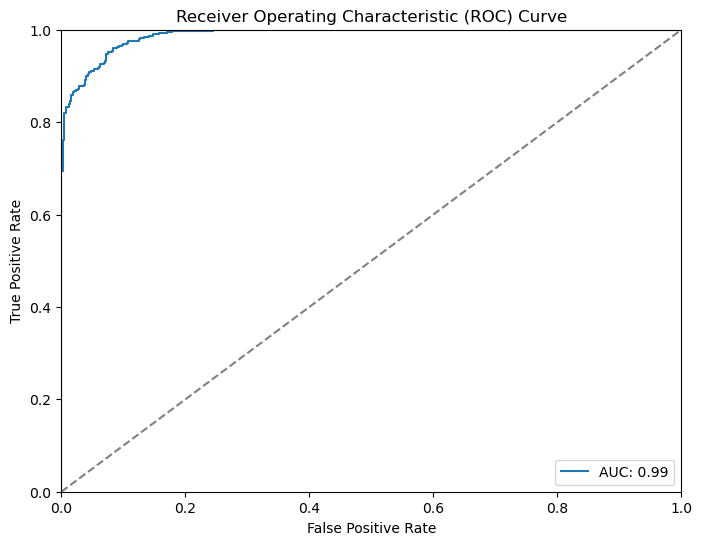

In [14]:
# Predict on the test dataset
predictions = loaded_trainer.predict(test_ds)

# Get the predicted probabilities and ground truth labels
predicted_probs = predictions.predictions[:, 1]  # Assuming class 1 is the positive class
ground_truth_labels = predictions.label_ids

# Calculate FPR, TPR, and AUC score
fpr, tpr, _ = roc_curve(ground_truth_labels, predicted_probs)
auc_score = roc_auc_score(ground_truth_labels, predicted_probs)

plot_roc_curve(fpr, tpr, auc_score)

## Visulization (best model: BEIT Base)

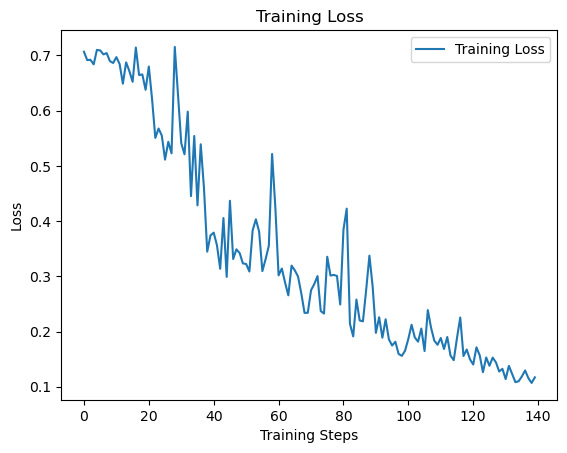

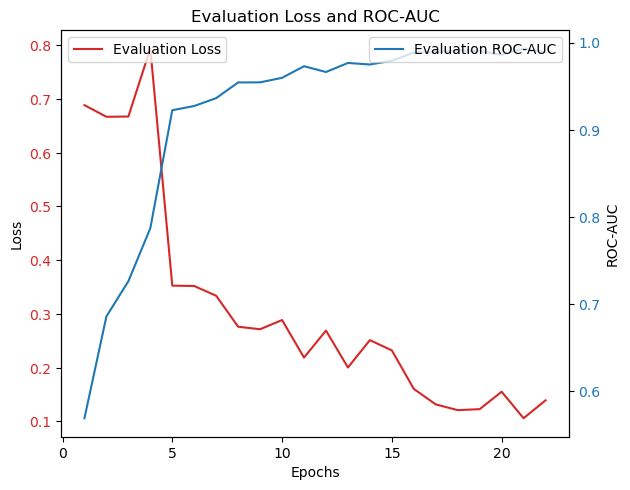

In [15]:
# Extract the training and evaluation history
training_history = pd.read_pickle(r'histories/beit.pkl')

# Extract the training loss, evaluation loss, and evaluation ROC-AUC
train_loss = [entry['loss'] for entry in training_history if 'loss' in entry]
eval_loss = [entry['eval_loss'] for entry in training_history if 'eval_loss' in entry]
eval_roc_auc = [entry['eval_roc_auc'] for entry in training_history if 'eval_roc_auc' in entry]

# Plot the training loss
plt.plot(train_loss, label="Training Loss")
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.show()

# Plot the evaluation loss and ROC-AUC
epochs = list(range(1, len(eval_loss) + 1))
fig, ax1 = plt.subplots()

ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.plot(epochs, eval_loss, label="Evaluation Loss", color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')
ax1.legend(loc='upper left')

ax2 = ax1.twinx() # instantiate a second axes that shares the same x-axis
ax2.set_ylabel("ROC-AUC")
ax2.plot(epochs, eval_roc_auc, label="Evaluation ROC-AUC", color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')
ax2.legend(loc='upper right')

fig.tight_layout() # otherwise the right y-label is slightly clipped
plt.title("Evaluation Loss and ROC-AUC")
plt.show()
